In [44]:
%pip install tensorflow numpy pandas scipy

Note: you may need to restart the kernel to use updated packages.


In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from scipy.optimize import minimize


In [46]:
data = pd.read_csv('torque_drag_dataset.csv')

# Split the dataset into input features (X) and target variables (y)
X = data[['Measured Depth (MD)', 'TVD', 'Inclination', 'Azimuth', 'WOB', 'RPM', 
          'Fluid Viscosity', 'Fluid Density', 'Dogleg Severity', 'Tripping Speed']].values
y_torque = data['Surface Torque'].values
y_drag = data['Hook Load'].values  # Drag force can be inferred from Hook Load

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_torque_train, y_torque_test, y_drag_train, y_drag_test = train_test_split(
    X, y_torque, y_drag, test_size=0.2, random_state=42)

In [48]:
# Define the model architecture
def build_model(input_dim):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(input_dim,)))
    model.add(layers.Dense(256, activation='relu')) 
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='linear'))  # Two outputs (Torque, Drag)
    return model

# Build the model
input_dim = X_train.shape[1]
model = build_model(input_dim)



In [49]:
# Use a simple optimization to fit physics-based parameters (mu, F_N)
from scipy.optimize import minimize

# Define a cost function to minimize the difference between actual and physics-based predictions
def cost_function(params):
    mu, F_N = params
    physics_torque = mu * F_N * r
    physics_drag = mu * F_N
    torque_loss = np.mean(np.square(physics_torque - predicted_torque))
    drag_loss = np.mean(np.square(physics_drag - predicted_drag))
    return torque_loss + drag_loss

# Initial guesses for mu and F_N
initial_guess = [0.3, 1.0]

# Minimize the cost function to find better mu and F_N
result = minimize(cost_function, initial_guess, method='BFGS')
optimal_mu, optimal_F_N = result.x

print(f"Optimized mu: {optimal_mu}, Optimized F_N: {optimal_F_N}")


Optimized mu: 0.3, Optimized F_N: 1.0


In [50]:
# Physics-informed loss function
def physics_informed_loss(y_true, y_pred, mu=optimal_mu, F_N=optimal_F_N):
    # Torque and Drag predictions
    torque_pred = y_pred[:, 0]
    drag_pred = y_pred[:, 1]
    
    # Data Loss (MSE)
    data_loss = tf.reduce_mean(tf.square(y_true[:, 0] - torque_pred)) + \
                tf.reduce_mean(tf.square(y_true[:, 1] - drag_pred))
    
    # Physics-based loss (with optimized mu and F_N)
    physics_torque_loss = tf.reduce_mean(tf.square(torque_pred - mu * F_N * r))
    physics_drag_loss = tf.reduce_mean(tf.square(drag_pred - mu * F_N))
    
    # Total loss
    total_loss = data_loss + 0.5 * (physics_torque_loss + physics_drag_loss)
    return total_loss

'''
def physics_informed_loss(y_true, y_pred):
    # Separate Torque and Drag predictions
    torque_pred = y_pred[:, 0]
    drag_pred = y_pred[:, 1]
    
    # Data Loss (MSE)
    data_loss = tf.reduce_mean(tf.square(y_true[:, 0] - torque_pred)) + \
                tf.reduce_mean(tf.square(y_true[:, 1] - drag_pred))
    
    # Physics-based loss (simplified as an example)
    # Torque = mu * F_N * r
    # Drag = mu * F_N
    
    # We assume F_N (normal force) and r (radius) as constants for simplicity
    mu = 0.3  # Friction coefficient (example value)
    F_N = 1.0  # Normal force approximation (to be improved with real data)
    r = 1.0  # Radius (to be customized based on your data)
    
    # Physics loss for Torque
    physics_torque_loss = tf.reduce_mean(tf.square(torque_pred - mu * F_N * r))
    
    # Physics loss for Drag
    physics_drag_loss = tf.reduce_mean(tf.square(drag_pred - mu * F_N))
    
    # Total loss (data loss + physics loss)
    total_loss = data_loss + 0.5 * (physics_torque_loss + physics_drag_loss)
    
    return total_loss
'''

'\ndef physics_informed_loss(y_true, y_pred):\n    # Separate Torque and Drag predictions\n    torque_pred = y_pred[:, 0]\n    drag_pred = y_pred[:, 1]\n    \n    # Data Loss (MSE)\n    data_loss = tf.reduce_mean(tf.square(y_true[:, 0] - torque_pred)) +                 tf.reduce_mean(tf.square(y_true[:, 1] - drag_pred))\n    \n    # Physics-based loss (simplified as an example)\n    # Torque = mu * F_N * r\n    # Drag = mu * F_N\n    \n    # We assume F_N (normal force) and r (radius) as constants for simplicity\n    mu = 0.3  # Friction coefficient (example value)\n    F_N = 1.0  # Normal force approximation (to be improved with real data)\n    r = 1.0  # Radius (to be customized based on your data)\n    \n    # Physics loss for Torque\n    physics_torque_loss = tf.reduce_mean(tf.square(torque_pred - mu * F_N * r))\n    \n    # Physics loss for Drag\n    physics_drag_loss = tf.reduce_mean(tf.square(drag_pred - mu * F_N))\n    \n    # Total loss (data loss + physics loss)\n    total_lo

In [51]:
# Custom loss function to combine data and physics-informed loss
def combined_loss(y_true, y_pred, alpha=1.0, beta=10.0):
    # Alpha controls data loss weight, Beta controls physics loss weight
    return alpha * physics_informed_loss(y_true, y_pred) + beta * physics_informed_loss(y_true, y_pred)


# Compile the model
model.compile(optimizer='adam', loss=combined_loss)


In [52]:
# Stack Torque and Drag together for the training targets
y_train = np.vstack((y_torque_train, y_drag_train)).T
y_test = np.vstack((y_torque_test, y_drag_test)).T


In [53]:
# Rebuild and compile the model with updated architecture
model = build_model(input_dim)
model.compile(optimizer='adam', loss=combined_loss)

# Retrain the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Recompile the model and retrain with early stopping
model.compile(optimizer='adam', loss=combined_loss)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 5988264448.0000 - val_loss: 5795924992.0000
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 5536798720.0000 - val_loss: 5389598720.0000
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 5099276800.0000 - val_loss: 4984447488.0000
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 4700527616.0000 - val_loss: 4576629248.0000
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 4138877696.0000 - val_loss: 4158129664.0000
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 3787850752.0000 - val_loss: 3725179136.0000
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 3374786304.0000 - val_loss: 3295404288.0000
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 3035273472.0000 - val_loss: 2894169088.0000
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2516414976.0000 - val_loss: 2543286528.0000
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2308231680.0000 - val_loss: 22801

In [54]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2186202112.0000 - val_loss: 2317460224.0000
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2145936768.0000 - val_loss: 2275945984.0000
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2114295296.0000 - val_loss: 2236702976.0000
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2110786944.0000 - val_loss: 2204801024.0000
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2130073600.0000 - val_loss: 2181446656.0000
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 2075794816.0000 - val_loss: 2166078464.0000
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2103113088.0000 - val_loss: 2159158016.0000
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2093117952.0000 - val_loss: 2158241024.0000
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2099374464.0000 - val_loss: 2159970560.0000
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 2133106048.0000 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2133476864.0000
Test Loss: 2133476864.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


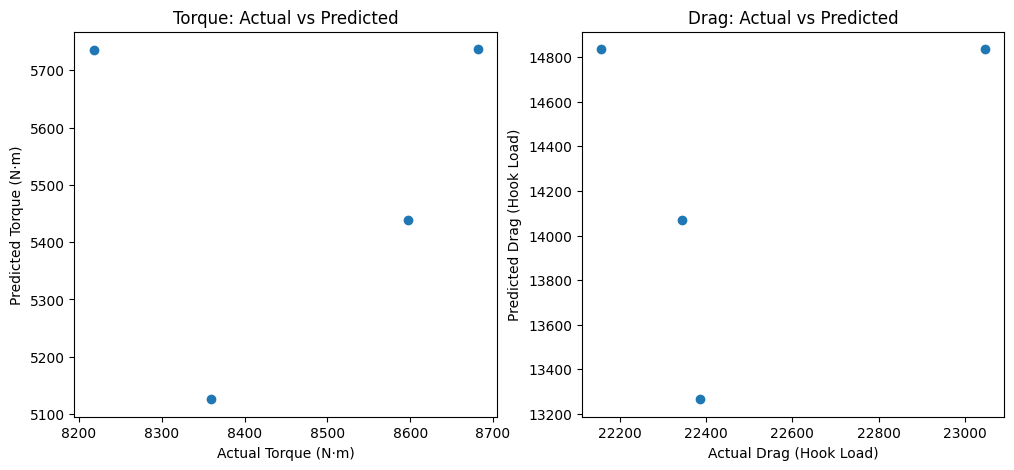

In [55]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Predict on the test set
y_pred = model.predict(X_test)

# Separate the predicted Torque and Drag
predicted_torque = y_pred[:, 0]
predicted_drag = y_pred[:, 1]

# Compare predictions with actual test data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_torque_test, predicted_torque)
plt.xlabel("Actual Torque (N·m)")
plt.ylabel("Predicted Torque (N·m)")
plt.title("Torque: Actual vs Predicted")

plt.subplot(1, 2, 2)
plt.scatter(y_drag_test, predicted_drag)
plt.xlabel("Actual Drag (Hook Load)")
plt.ylabel("Predicted Drag (Hook Load)")
plt.title("Drag: Actual vs Predicted")

plt.show()


In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on the test data
y_pred = model.predict(X_test)

# Separate the predicted Torque and Drag
predicted_torque = y_pred[:, 0]
predicted_drag = y_pred[:, 1]

# Separate the true Torque and Drag values for comparison
true_torque = y_test[:, 0]
true_drag = y_test[:, 1]

# Calculate the evaluation metrics for Torque
mse_torque = mean_squared_error(true_torque, predicted_torque)
mae_torque = mean_absolute_error(true_torque, predicted_torque)
r2_torque = r2_score(true_torque, predicted_torque)

# Calculate the evaluation metrics for Drag
mse_drag = mean_squared_error(true_drag, predicted_drag)
mae_drag = mean_absolute_error(true_drag, predicted_drag)
r2_drag = r2_score(true_drag, predicted_drag)

# Print the evaluation results
print(f"Torque MSE: {mse_torque}, MAE: {mae_torque}, R²: {r2_torque}")
print(f"Drag MSE: {mse_drag}, MAE: {mae_drag}, R²: {r2_drag}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Torque MSE: 8818160.633678447, MAE: 2955.0449267578124, R²: -257.12146605336073
Drag MSE: 68165035.24736619, MAE: 8231.625537109376, R²: -601.5011409360125


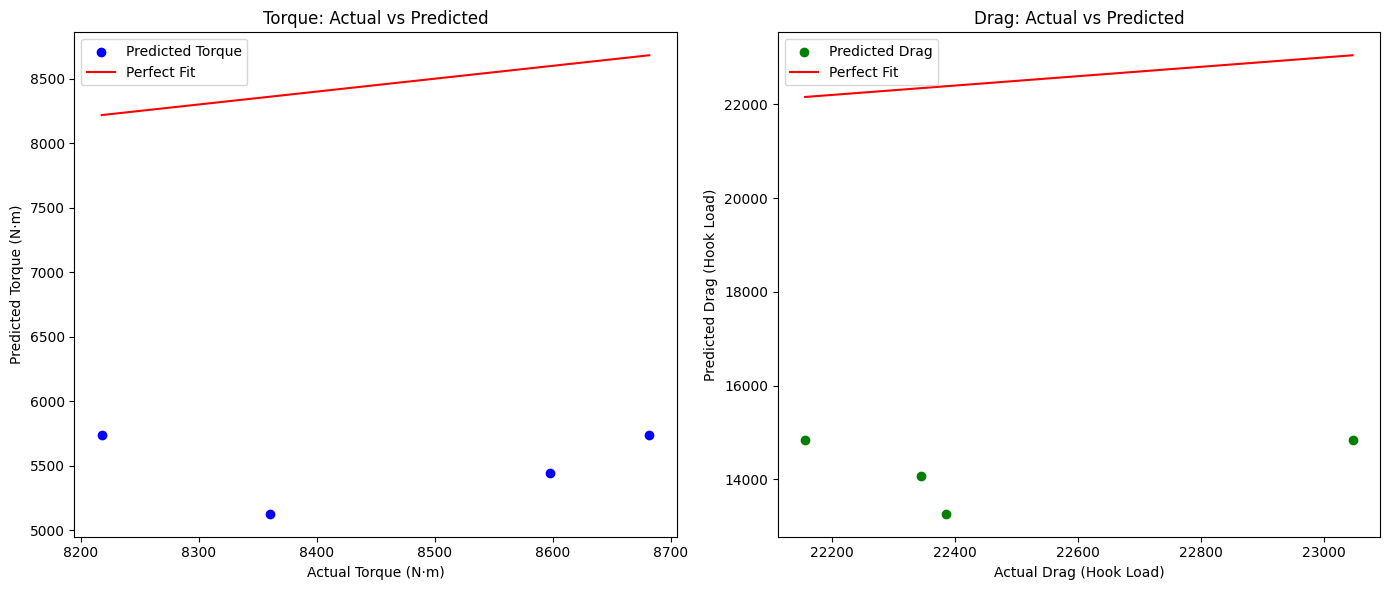

In [57]:
import matplotlib.pyplot as plt

# Plot the comparison for Torque
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(true_torque, predicted_torque, color='blue', label='Predicted Torque')
plt.plot([min(true_torque), max(true_torque)], [min(true_torque), max(true_torque)], color='red', label='Perfect Fit')
plt.xlabel('Actual Torque (N·m)')
plt.ylabel('Predicted Torque (N·m)')
plt.title('Torque: Actual vs Predicted')
plt.legend()

# Plot the comparison for Drag
plt.subplot(1, 2, 2)
plt.scatter(true_drag, predicted_drag, color='green', label='Predicted Drag')
plt.plot([min(true_drag), max(true_drag)], [min(true_drag), max(true_drag)], color='red', label='Perfect Fit')
plt.xlabel('Actual Drag (Hook Load)')
plt.ylabel('Predicted Drag (Hook Load)')
plt.title('Drag: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()


In [58]:
# Physics consistency check (simplified)
mu = 0.3  # Friction coefficient (example)
F_N = 1.0  # Normal force (assumed constant for this example)
r = 1.0  # Radius (assumed constant for this example)

# Calculate physics-based predictions for torque and drag
physics_torque = mu * F_N * r
physics_drag = mu * F_N

# Compare physics-based predictions with actual model predictions
print(f"Physics-based Torque: {physics_torque}")
print(f"Predicted Torque Mean: {np.mean(predicted_torque)}")

print(f"Physics-based Drag: {physics_drag}")
print(f"Predicted Drag Mean: {np.mean(predicted_drag)}")


Physics-based Torque: 0.3
Predicted Torque Mean: 5509.2626953125
Physics-based Drag: 0.3
Predicted Drag Mean: 14251.76171875
